# Brief Overview on How to Use the MultiViz Analytics Engine Library

## Introduction

The MultiViz Vibration Service is an analytics service based on the MultiViz Vibration Engine.
To access it Viking Analytics provides a REST API towards its analytics server.
To simplify the access of the Vibration service, Viking Analytics provides a Python Package
called MVG, which allows to interact with the vibration service via regular python calls.

This interactive document shall show the whole flow working with the vibration service from
Python, from data upload to retrieval of analysis results.

### Signing up for the service

For commercial use of the services you will need to acquire a token from Viking Analytics.
For the example here, we can use a built in token for demo, we also use a special


### Python Pre-requisites

1. Make sure you have Python 3.6 or higher installed.
2. Install the MVG package from ["https://pypi.org/project/va-mvg/"](https://pypi.org/project/va-mvg/)
3. Make sure you have the following packages installed (json, matplotlib...)

In the following section we will walk through the code needed for the API interaction

## Imports

First, we begin with the general imports of Python libraries that are needed as part of this project

In [1]:
import json
import os
import sys
from pathlib import Path
import pandas as pd
from requests import HTTPError

We proceed by installing the MVG library in our project

In [2]:
!{sys.executable} -m pip install --user va-mvg

ERROR: Can not perform a '--user' install. User site-packages are not visible in this virtualenv.


We follow by importing MVG library.

The library documentation is available at https://vikinganalytics.github.io/mvg/index.html

In [3]:
from mvg import MVG

We begin by instantiating a "session" object with the mvg library.
A session object basically caches the endpoint and the token, to simplify the the calls to the mvg library.

NOTE: Each TOKEN is used for Authorization AND Authentication.
Thus, each unique token represents a unique user, each user has it own, unique database on the VA vibration' service

In [4]:
ENDPOINT = "https://api.beta.multiviz.com"
# Replace by your own Token
VALID_TOKEN = "Add token here"

In [5]:
session = MVG(ENDPOINT, VALID_TOKEN)

We now check if the server is alive.
The hello message contains the API version

In [6]:
hello_message = json.dumps(session.say_hello())
hello_message

'{"api": {"name": "MultiViz Engine API", "version": "v0.0.13"}, "features": {"mode_id": true, "blacksheep": false, "emerging_mode": false, "on_off": false, "asset_type": false, "indicator_arrow": false}, "request_status": ["initialized", "accepted", "queued", "ongoing", "failed", "ready"], "traffic_limit": 10000000, "max_source_id_length": 255, "max_meta_size": 50000, "max_number_of_samples": 400000, "max_number_of_sources": 100, "max_number_of_measurements": 1000, "db_version": "1.0.0"}'

## Sources and Measurements

Before we begin, we will ensure there are no  previously existing sources and if there are, we will delete them.

In [7]:
sources = session.list_sources()

print("Retrieved sources")
for src in sources:
    print(src)
    print(f"Deleting {src['source_id']}")
    session.delete_source(src['source_id'])

Retrieved sources
{'source_id': 'u0001', 'meta': {'assetId': 'assetA', 'measPoint': 'mloc01', 'location': 'paris'}}
Deleting u0001


The example below revolves around a sources with source_id "u0001".

For convenience, this source and its measurements are available with the package distribution.

You can retrieve the data from our public charlie repo https://github.com/vikinganalytics/va-data-charlie.git

In [8]:
!git clone https://github.com/vikinganalytics/va-data-charlie.git

fatal: destination path 'va-data-charlie' already exists and is not an empty directory.


In [9]:
# Path to the source folder
REF_DB_PATH = Path.cwd() / "va-data-charlie" / "charlieDb" / "acc"
REF_DB_PATH
# Definition of the source_id
SOURCE_ID = "u0001"
SOURCE_ID


'u0001'

### Creating a Source

A source represents a vibration data source, typically a vibration sensor.
Internally, in the analytics engine and data storage, all vibration data is stored under its source. 
In essence, a source is an identifier formed by
 - the source ID
 - meta data with required fields
 - optional arbitrary customer specific 'free form' data belonging to the source.
 
The vibration service will only rely on the required fields.
The free form data is a possibility for the client side to keep together source information, measurements and meta data which may be interesting for the analytics built-in features in the service.
Examples of the free form data include location of sensor or the asset which it is mounted on.
As we will see later, timestamps are internally represented as millisconds since EPOCH (Jan 1st 1970), for that reason it is good practice to include the timezone where the measurement originated in the meta data.

There are two ways to create a source:

In [10]:
# OPTION 1: Writing the meta-data directly when creating the source
SOURCE_IDP = "u001"
meta_information = {'assetId': 'assetJ', 'measPoint': 'mloc01', 'location': 'cancun', 'timezone': 'Europe/Stockholm'}
session.create_source(SOURCE_IDP, meta_information)
session.get_source(SOURCE_IDP)
session.delete_source(SOURCE_IDP)

In [11]:
# OPTION 2: Uploading the meta-data from a json file
src_path = REF_DB_PATH / SOURCE_ID
meta_filename = src_path / "meta.json"
with open(meta_filename, "r") as json_file:
    meta = json.load(json_file)
session.create_source(SOURCE_ID, meta)
session.get_source(SOURCE_ID)

{'source_id': 'u0001',
 'meta': {'assetId': 'assetA', 'measPoint': 'mloc01', 'location': 'paris'}}

List sources

We can now check if our source actually has been created, by listing all the sources in the database.

In [12]:
sources = session.list_sources()
sources

[{'source_id': 'u0001',
  'meta': {'assetId': 'assetA', 'measPoint': 'mloc01', 'location': 'paris'}}]

### Uploading a Measurement

Now that we have created a source, we can upload vibration measurements related to the source. 
The information needed to create a measurement consists of
- sid: name of the source ID to associate the measurement with a source.
- duration: float value that represent the duration, in seconds, of the measurement to estimate the sampling frequency.
- timestamp: integer representing the milliseconds since EPOCH of when the measurement was taken.
- data: list of floating point values representing the raw data of the vibration measurement.
- meta: additional meta information for later use by the client but not to be processed by the analytics engine.

In this example, all the measurement data is stored as csv and json files, where the timestamp is the name of each of these files.

In [13]:
# meas is a list of timestamps representing the measurements in our repo
meas = {f.split(".")[0] for f in os.listdir(src_path)}
# We remove the "meta" file from this list
meas.remove("meta")


In [14]:
# We iterate over all of elements in this list
for m in meas:

    # raw data per measurement
    TS_MEAS = str(m) + ".csv"  # filename
    TS_MEAS = REF_DB_PATH / SOURCE_ID / TS_MEAS  # path to file
    ts_df = pd.read_csv(TS_MEAS, names=['acc'])  # read csv into df
    accs = ts_df.iloc[:, 0].tolist()  # convert to list
    print(f"Read {len(accs)} samples")

    # meta information file per measurement
    TS_META = str(m) + ".json"  # filename
    TS_META = REF_DB_PATH / SOURCE_ID / TS_META  # path
    with open(TS_META, "r") as json_file:  # read json
        meas_info = json.load(json_file)  # into dict
    print(f"Read meta:{meas_info}")

    # get duration and other meta info
    duration = meas_info['duration']
    meta_info = meas_info['meta']

    # Upload measurements
    print(f"Uploading {TS_MEAS}")
    try:
        session.create_measurement(sid=SOURCE_ID, 
                                   duration=duration, 
                                   timestamp=m, 
                                   data=accs, 
                                   meta=meta_info)
    except HTTPError as exc:
        print(exc)

Read 40000 samples
Read meta:{'duration': 2.8672073400507907, 'meta': {}}
Uploading /home/oskar/viking_unix/mvg/docs/source/content/examples/va-data-charlie/charlieDb/acc/u0001/1570359660.csv
Read 40000 samples
Read meta:{'duration': 2.8672073400507907, 'meta': {}}
Uploading /home/oskar/viking_unix/mvg/docs/source/content/examples/va-data-charlie/charlieDb/acc/u0001/1571050860.csv
Read 40000 samples
Read meta:{'duration': 2.8672073400507907, 'meta': {}}
Uploading /home/oskar/viking_unix/mvg/docs/source/content/examples/va-data-charlie/charlieDb/acc/u0001/1573041660.csv
Read 40000 samples
Read meta:{'duration': 2.8672073400507907, 'meta': {}}
Uploading /home/oskar/viking_unix/mvg/docs/source/content/examples/va-data-charlie/charlieDb/acc/u0001/1570273260.csv
Read 40000 samples
Read meta:{'duration': 2.8672073400507907, 'meta': {}}
Uploading /home/oskar/viking_unix/mvg/docs/source/content/examples/va-data-charlie/charlieDb/acc/u0001/1571223660.csv
Read 40000 samples
Read meta:{'duration'

Read 40000 samples
Read meta:{'duration': 2.8672073400507907, 'meta': {}}
Uploading /home/oskar/viking_unix/mvg/docs/source/content/examples/va-data-charlie/charlieDb/acc/u0001/1570532460.csv
Read 40000 samples
Read meta:{'duration': 2.8672073400507907, 'meta': {}}
Uploading /home/oskar/viking_unix/mvg/docs/source/content/examples/va-data-charlie/charlieDb/acc/u0001/1573128060.csv
Read 40000 samples
Read meta:{'duration': 2.8672073400507907, 'meta': {}}
Uploading /home/oskar/viking_unix/mvg/docs/source/content/examples/va-data-charlie/charlieDb/acc/u0001/1572523260.csv
Read 40000 samples
Read meta:{'duration': 2.8672073400507907, 'meta': {}}
Uploading /home/oskar/viking_unix/mvg/docs/source/content/examples/va-data-charlie/charlieDb/acc/u0001/1573473660.csv
Read 40000 samples
Read meta:{'duration': 2.8672073400507907, 'meta': {}}
Uploading /home/oskar/viking_unix/mvg/docs/source/content/examples/va-data-charlie/charlieDb/acc/u0001/1571742060.csv
Read 40000 samples
Read meta:{'duration'

Check if we actually created the measurements by reading them.

In [15]:
m = session.read_measurements(SOURCE_ID)
print(f"Read {len(m)} stored measurements")

Read 50 stored measurements


## Analysis

We begin by listing all the features available in the service

In [16]:
available_features = session.supported_features()
available_features

{'RMS': '0.0.1', 'ModeId': '0.1.0'}

In this example, we will request both features to be applied to the previously defined SOURCE_ID.

We will begin with the 'RMS' feature, which provides the RMS for each signal.
Thus, we proceed to request the analysis to the VA Vibration service.

In [17]:
RMS_u0001 = session.request_analysis(SOURCE_ID, 'RMS')
RMS_u0001

{'request_id': 'e4596c662ec5b1b14f4ef8dd6bb8cca1', 'request_status': 'ongoing'}

The requested analysis will return a dictionary object with two elements.
The first element is a `"request_id"` that can be used to retrieve the results after.
The second element is `"request_status"` that provides the status right after placing the analysis request. 

Before we are able to get the analysis results, we need to wait until those results are successfully completed.

We can query for the status of our requested analysis.
The possible status are:
- Queued: The analysis has not started in the remote server and it is in the queue to begin.
- Ongoing: The analysis is been processed at this time.
- Failed: The analysis is complete and failed to produce a result.
- Successful: The analysis is complete and it successfully produced a result.

In [18]:
REQUEST_ID_RMS_u0001 = RMS_u0001['request_id']
status = session.get_analysis_status(REQUEST_ID_RMS_u0001)
print(f"RMS Analysis: {status}")

RMS Analysis: ongoing


The next feature is 'ModeId'.
The 'ModeId' feature displays all the operating modes over time of an individual asset. 
The similar procedure is repeated to request the analysis of the "ModeId" feature for our source "u0001".

In [19]:
ModeId_u0001 = session.request_analysis(SOURCE_ID, 'ModeId')
ModeId_u0001 

{'request_id': '9c99a0fa8b26f8c6409fc4233f35b688', 'request_status': 'ongoing'}

We also check the status for our second source.

In [20]:
REQUEST_ID_ModeId_u0001 = ModeId_u0001['request_id']
status = session.get_analysis_status(REQUEST_ID_ModeId_u0001)
print(f"ModeId Analysis: {status}")

ModeId Analysis: ongoing


We can proceed to get the results by calling the corresponding requestIds for the feature of each source.

The output of the get_analysis_results function is a dictionary and we show the keys of one those dictionaries.
The keys are the same for all features and contains two elements.
The first key `"status"` indicates if the analysis was succesful.
The second key `"results"` includes the numeric results.

In [21]:
rms_table = session.get_analysis_results(jobid=REQUEST_ID_RMS_u0001)
mode_table = session.get_analysis_results(jobid=REQUEST_ID_ModeId_u0001)

rms_table.keys()

dict_keys(['status', 'results'])

The `"results"` of the "RMS" feature are two lists.
One list corresponds to the timestamp of a measurement and the other list contains the rms value for the measurement.

These lists can be converted into a dataframe for ease of manipulation.
In addition, the "timestamp" column is converted to a timestamp object.

In [22]:
df_rms = pd.DataFrame(rms_table["results"])
df_rms['Timestamp'] = pd.to_datetime(df_rms['Timestamp'], format='%Y-%m-%d %H:%M:%S')
df_rms.head()

,Timestamp,rms
0,2019-10-04 11:01:00,0.662108
1,2019-10-05 11:01:00,0.662183
2,2019-10-06 11:01:00,0.661652
3,2019-10-07 11:01:00,0.661923
4,2019-10-08 11:01:00,0.661714


The `"results"` of the "ModeId" feature is a dictionary and two lists.
The dictionary contains the timestamps, where an index value represents the key and the timestamp is the dictionary value.
The first list corresponds to the mode label given to the timestamp.
The second list is a boolean to indicate the uncertainty of label.

We extract the timestamp values into a list, which will be later converted to a timestamp object.
We pass all the lists to a dataframe for ease of manipulation. 

In [23]:
mode_results = mode_table["results"] 
column_heads = list(mode_results.keys())
timestamp_list = list(mode_results['timestamps'].values())

df_mode = pd.DataFrame({column_heads[0] : timestamp_list, column_heads[1] : mode_results['labels'], column_heads[2] : mode_results['uncertain']})
df_mode['Timestamp'] = pd.to_datetime(df_mode['timestamps'], format='%Y-%m-%d %H:%M:%S')

df_mode.head()

,timestamps,labels,uncertain,Timestamp
0,2019-10-04 11:01:00,1,False,2019-10-04 11:01:00
1,2019-10-05 11:01:00,1,False,2019-10-05 11:01:00
2,2019-10-06 11:01:00,1,False,2019-10-06 11:01:00
3,2019-10-07 11:01:00,1,False,2019-10-07 11:01:00
4,2019-10-08 11:01:00,1,False,2019-10-08 11:01:00


### Visualization

We can use those results to generate some plots that may ease the visualization.

The MVG framework provides some visualization functions that can help towards this goal.
We begin by importing the visualization module

In [24]:
from mvg import plotting
%matplotlib inline

One of the provided functions enable to display the different modes over time.
This way we can identify all its modes.

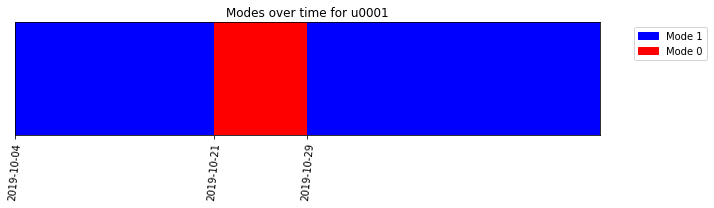

In [25]:
image_modes = plotting.modes_over_time(df_mode, SOURCE_ID)

We can call the individual boxplot for one source and display the boxplot of the "RMS" for each one of the operating modes.
However, we need to merge the "RMS" and "ModeId" dataframes first.

In [26]:
df_u0001 =  pd.merge_asof(df_rms, df_mode, on="Timestamp")
df_u0001.head()

,Timestamp,rms,timestamps,labels,uncertain,Date
0,2019-10-04 11:01:00,0.662108,2019-10-04 11:01:00,1,False,2019-10-04 11:01:00
1,2019-10-05 11:01:00,0.662183,2019-10-05 11:01:00,1,False,2019-10-05 11:01:00
2,2019-10-06 11:01:00,0.661652,2019-10-06 11:01:00,1,False,2019-10-06 11:01:00
3,2019-10-07 11:01:00,0.661923,2019-10-07 11:01:00,1,False,2019-10-07 11:01:00
4,2019-10-08 11:01:00,0.661714,2019-10-08 11:01:00,1,False,2019-10-08 11:01:00


Now, we can proceed to plot the boxplot.

<AxesSubplot:title={'center':'Boxplot for u0001'}, xlabel='Modes', ylabel='rms'>

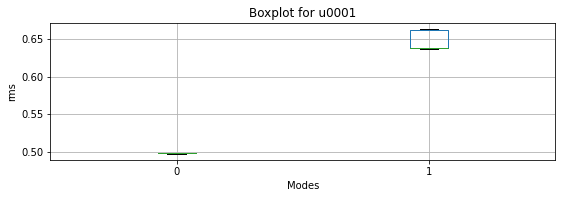

In [27]:
plotting.modes_boxplot(df_u0001, "rms", SOURCE_ID)

Here we conclude our brief overview to begin using the MultiViz Vibration Service.